The goal of this project is given an image and a 'c' number of levels, separate the colors of the image in c different sets, create a list taking the most representative color of each set and map each color of the image to the nearest color from that list. 

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

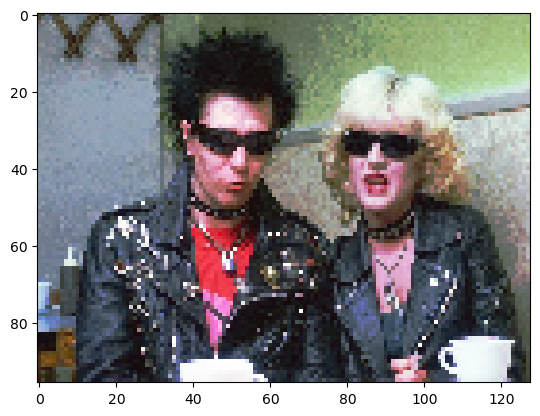

In [11]:
# read sid-and-nancy.png full color
img_orig = cv.imread('sid-and-nancy.png', cv.IMREAD_COLOR)
img_orig = cv.cvtColor(img_orig, cv.COLOR_BGR2RGB)

# plot image
plt.imshow(img_orig)
plt.show()


The first thing that we will implement is a function that allows us to, given a list of colors, map each color from the image to that color

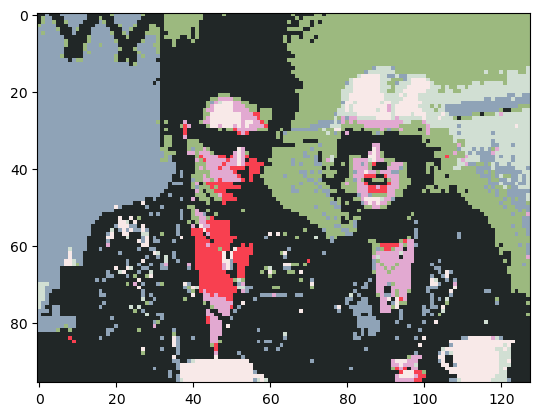

In [12]:
def v3_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

## maps each pixel from an image to the nearest color in a list

colors_to_map = [
    [248,233,232],
    [143,163,183],
    [209,223,211],
    [248,64,80],
    [33,39,39],
    [156,185,127],
    [226,169,209]
]

def map_colors(colors_to_map, img):
    img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color
    return img
        
mapped_img = map_colors(colors_to_map, img_orig)
# plot the image
plt.imshow(mapped_img)




As we can see, the problem with this approach is that we have the colors from the wall as the most common ones, causing the resulting image to only use them. This can be solved thanks to a technique called k-means clustering. This algorithm will plot all the colors in a 3D space and group together the colors based on distance.

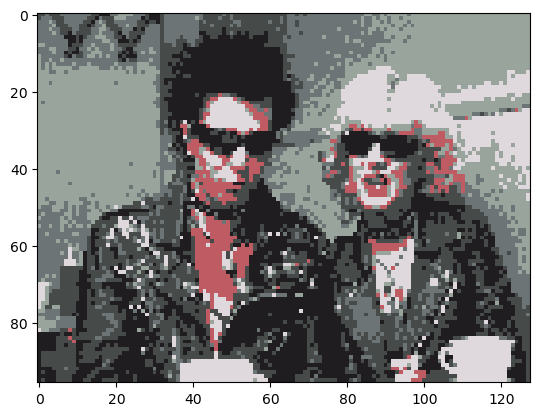

In [15]:
from sklearn.cluster import KMeans

def filter_colors_k_means(n_clusters, img):
    clt = KMeans(n_clusters=n_clusters)
    clt.fit(img.reshape(-1,3))
    colors_to_map = clt.cluster_centers_
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color    
    return img


img = img_orig.copy()
img = filter_colors_k_means(6, img)
plt.imshow(img)
plt.show()

K-mean color mapping works perfectly for our purposes, but, however, this technique presents the problem that for lower clusters will remove most of remarkable colors from the image (i.e. sid's red t-shirt) while when we use larger clusters it will allow tons of unwanted noise from the image. So, lets think. What if now that we have the colors separated in, lets say, 20 clusters and we take the most differentiated ones.

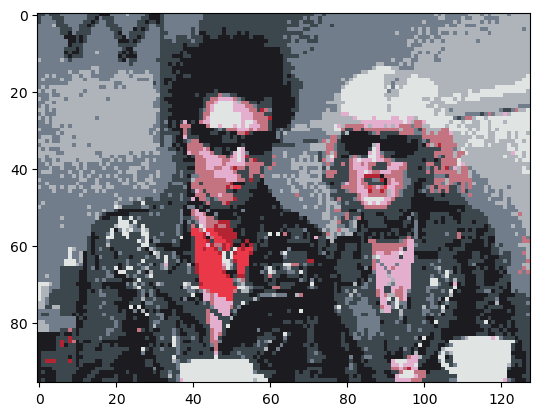

In [17]:
def filter_colors_k_means(n_clusters, img, filter_th=None):
    clt = KMeans(n_clusters=n_clusters)
    clt.fit(img.reshape(-1,3))
    colors_to_map = clt.cluster_centers_

    if filter_th is not None:
        indexes_to_delete = []
        for i in range(len(colors_to_map)):
            for j in range(i):
                if v3_distance(colors_to_map[i], colors_to_map[j]) < filter_th:
                    indexes_to_delete.append(i)
                    break

        colors_to_map = np.delete(colors_to_map, indexes_to_delete, axis=0)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color    
    return img


img = img_orig.copy()
image_f = filter_colors_k_means(30, img, 55)

# plot image
plt.imshow(image_f)
plt.show()

As we have seen, this funcion works perfectly for when we want an automated solution to the mapping colors problem. However, the quality of the first picture using curated colors is still greater than the one performed by k-means algorithm. What if we developed an algorithm that using OpenCV built-in visualizer allows us to select the colors that we want in the image and after that perform a color mapping?

In [93]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

window_name = "color_mapper"

def v3_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

def map_colors(colors_to_map, img):
    img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color
    return img
        


def get_color(event,x,y,flags,param):
    image = param[0]
    target_colors = param[1]

    if event == cv.EVENT_LBUTTONDOWN:
        color = image[y,x]
        # turn color into int rgb
        color = [int(color[2]), int(color[1]), int(color[0])]
        target_colors.append(color)

def get_points(image):
    color_list = []
    
    cv.namedWindow(window_name, cv.WINDOW_NORMAL)
    cv.imshow(window_name, image)
    cv.setMouseCallback(window_name, get_color,param=[image, color_list])

    while(1):
        cv.imshow(window_name, image)
        if cv.waitKey(20)==ord('r'):
            cv.destroyAllWindows()
            return color_list
        if cv.waitKey(20)==ord('q'):
            cv.destroyAllWindows()
            break

image = cv.imread("sid-and-nancy.png", cv.IMREAD_COLOR)
#image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
target_colors = get_points(image)

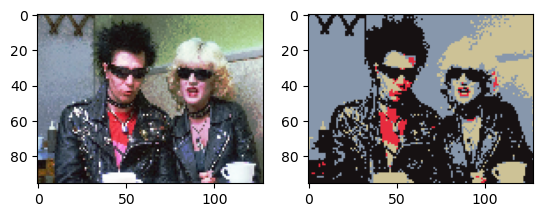

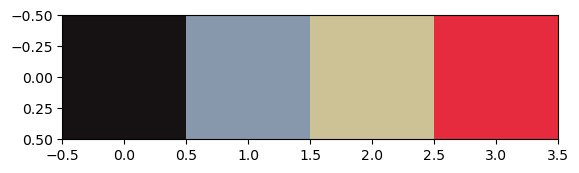

In [94]:
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
mapped_img = map_colors(target_colors, image_rgb)

# plot image and mapped
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
plt.imshow(mapped_img)
plt.show()

# get unique colors from image
image_colors = np.unique(mapped_img.reshape(-1, mapped_img.shape[2]), axis=0)
# plot colors
plt.imshow(image_colors.reshape(1,-1,3))

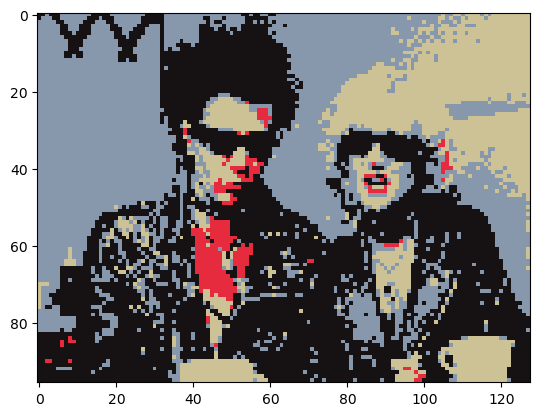

In [95]:
# plot mapped image and its colors
plt.imshow(mapped_img)
plt.show()


Now the picture is looking good, however, we can still improve it by removing noise. For example, what about one single white pixel in the picture being surrounded by black pixels (i.e. sid's studs in the jacket?). Well, we may like how they look but we could also want to remove them. In order to accomplish this, when computing the color distance instead of computing the distance between the pixel color and the target color we will compute a kernel average of the surrounding pixels. 

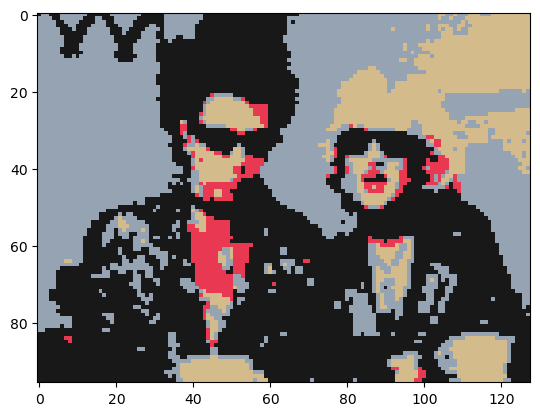

In [82]:
def average_channel(channel, kernel):
    for i in range(channel.shape[0]-kernel.shape[0]):
        for j in range(channel.shape[1]-kernel.shape[1]):
            channel[i,j] = np.mean(kernel * channel[i:i+kernel.shape[0], j:j+kernel.shape[1]])
    return channel


def average_pixel_color(image, kernel):
    image = image.copy()
    for channel in range(image.shape[2]):
        image[:,:,channel] = average_channel(image[:,:,channel], kernel)
    return image

def map_colors_avg(colors_to_map, img, kernel_size):
    img = img.copy()
    img_avg = average_pixel_color(img, np.ones((kernel_size, kernel_size)))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img_avg[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color
    return img

image = cv.imread("sid-and-nancy.png", cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_avg = map_colors_avg(target_colors, image, 2)

# plot image and image_avg
plt.imshow(image_avg)
plt.show()

That... didnt work as expected. We ended just having a blurred version of the picture that does not keep resemblance with the original or our target goal. However, there is another thing that we can do: As we have a limited ammount of n colors we could create n thresholded images (i.e in black or white) where a white pixel means that the image has a color n in that pixel, and, after that, perform morphological operations in order to remove single pixels or to dilate closed areas

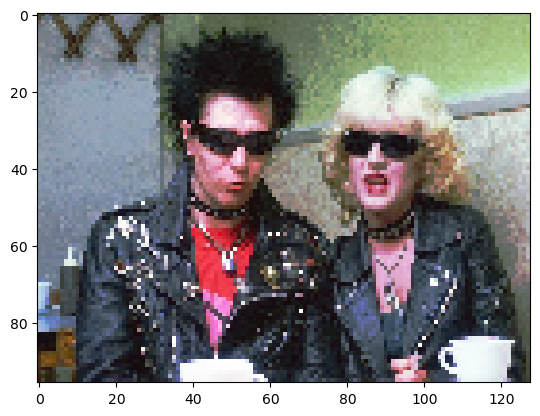

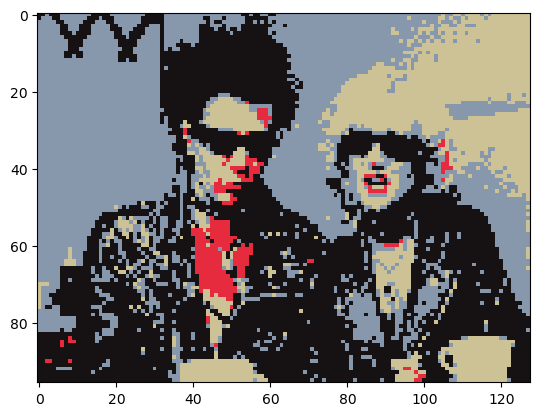

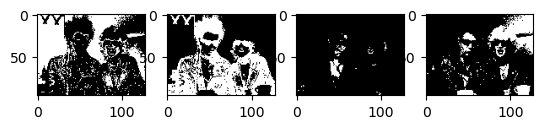

In [123]:
def separate_image_by_colors(img, colors):
    images = []
    for color in colors:
        img_c = np.zeros(img.shape, dtype=np.uint8)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                pixel = img[i,j]
                if np.all(pixel == color):
                    img_c[i,j] = 255
        images.append(img_c)
    return images


image = cv.imread("sid-and-nancy.png", cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# plot image
plt.imshow(image)
plt.show()

image_map = map_colors(target_colors, image)
# plot mapped image
plt.imshow(image_map)
plt.show()

images_color = separate_image_by_colors(image_map, target_colors)

# plot images
for i in range(len(images_color)):
    plt.subplot(1, len(images_color), i+1)
    plt.imshow(images_color[i]) 
plt.show()

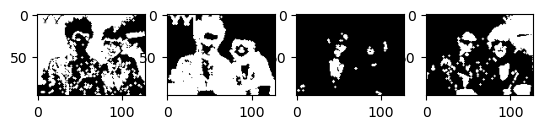

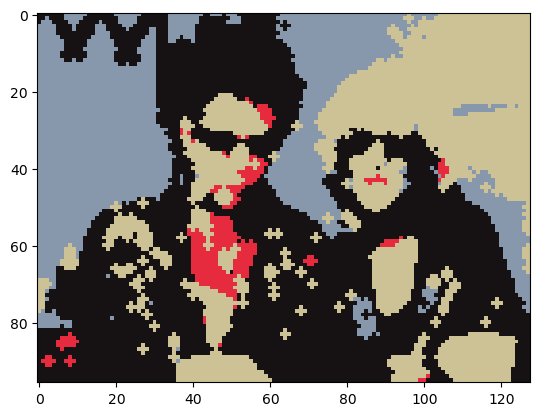

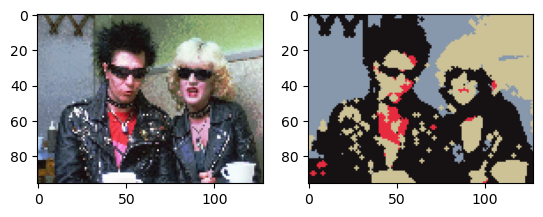

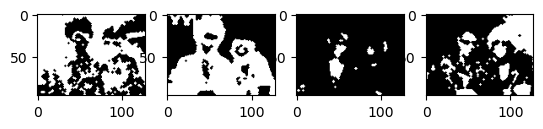

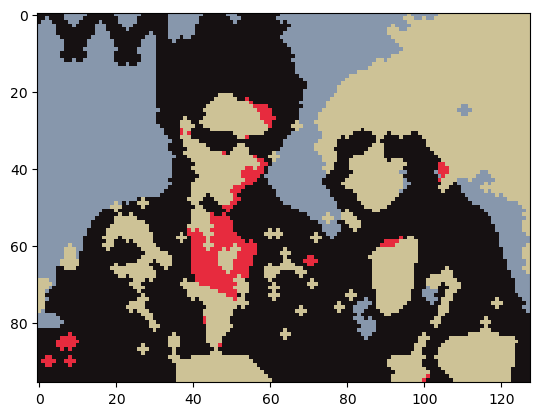

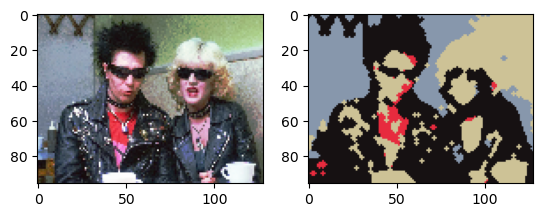

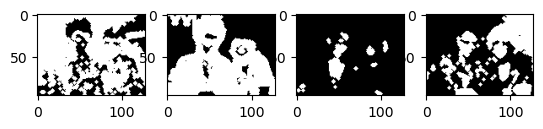

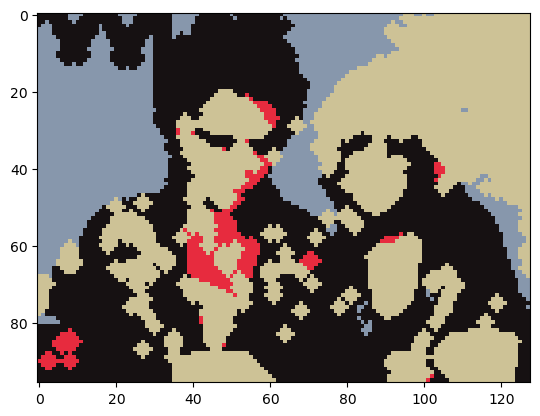

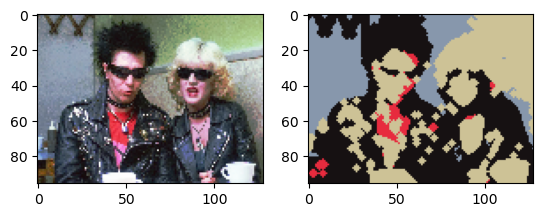

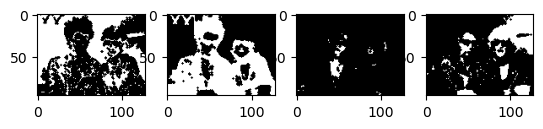

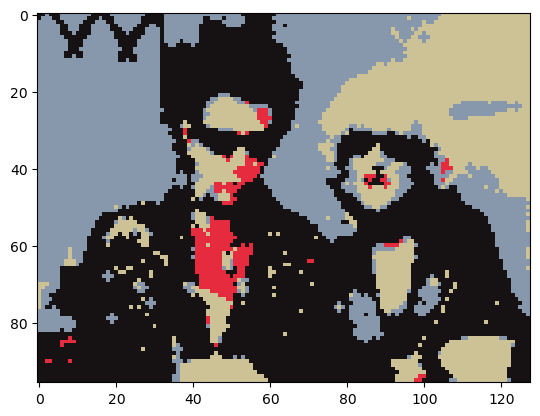

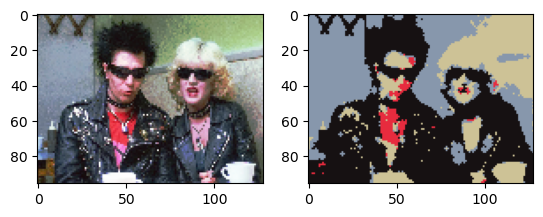

In [169]:
# return colors to image
def return_colors_to_image(images_color, target_colors):
    rebuilt_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(len(images_color)):
        for j in range(images_color[i].shape[0]):
            for k in range(images_color[i].shape[1]):
                if np.all(images_color[i][j,k] == 255):
                    # set color int
                    rebuilt_image[j,k] = [int(target_colors[i][0]), int(target_colors[i][1]), int(target_colors[i][2])]

    # fix black colors using most common color from neighboring pixels
    for i in range(rebuilt_image.shape[0]):
        for j in range(rebuilt_image.shape[1]):
            if np.all(rebuilt_image[i,j] == 0):
                # get neighboring pixels
                neighbors = []
                for k in range(-1,2):
                    for l in range(-1,2):
                        if i+k >= 0 and i+k < rebuilt_image.shape[0] and j+l >= 0 and j+l < rebuilt_image.shape[1] and rebuilt_image[i+k,j+l].any():
                            neighbors.append(tuple(rebuilt_image[i+k,j+l]))
                
                # get most common color
                most_common_color = max(set(neighbors), key=neighbors.count)
                rebuilt_image[i,j] = list(most_common_color)
    return rebuilt_image

# plot image 
kernel_size = 3
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))

# list of morphological operations
morph_operations = [cv.MORPH_OPEN, cv.MORPH_CLOSE, cv.MORPH_DILATE, cv.MORPH_ERODE]

for op in morph_operations:
    images_color_denoise = []
    for i in range(len(images_color)):
        img = images_color[i][1]
        images_color_denoise.append(cv.morphologyEx(images_color[i][1],op, kernel))

    # plot images
    for i in range(len(images_color_denoise)):
        plt.subplot(1, len(images_color_denoise), i+1)
        plt.imshow(images_color_denoise[i])
    plt.show()

    rebuilt_image = return_colors_to_image(images_color_denoise, target_colors)

    image_colors = np.unique(rebuilt_image.reshape(-1, rebuilt_image.shape[2]), axis=0)

    # plot rebuilt image   
    plt.imshow(rebuilt_image)
    plt.show()

    # plot image original and rebuilt
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(rebuilt_image)
    plt.show()

Now that we have tested different morphological operators on all the channels of the image we will perform the same task on a bigger image

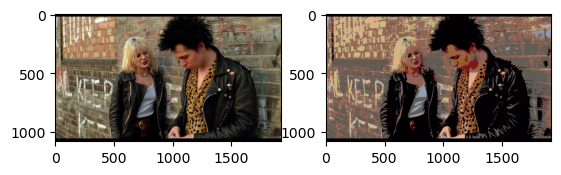

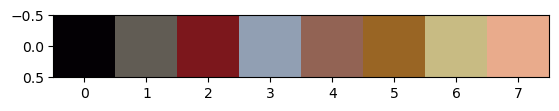

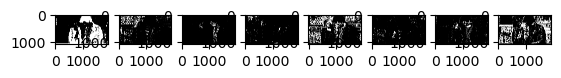

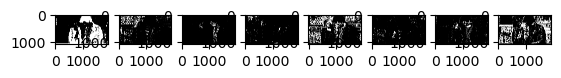

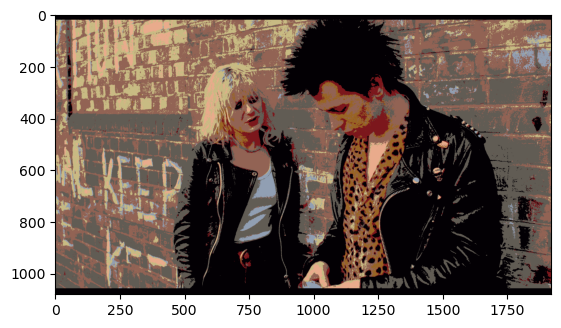

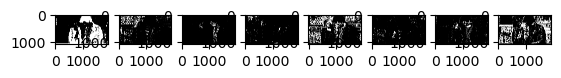

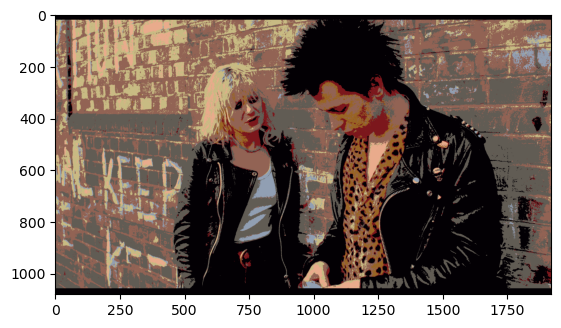

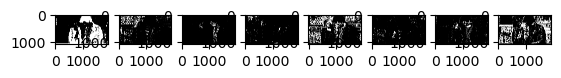

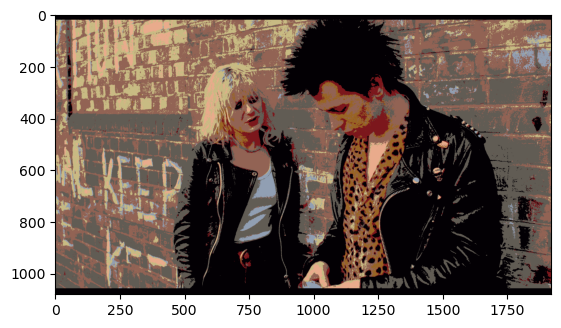

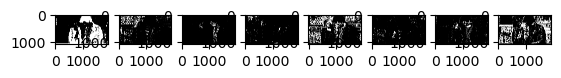

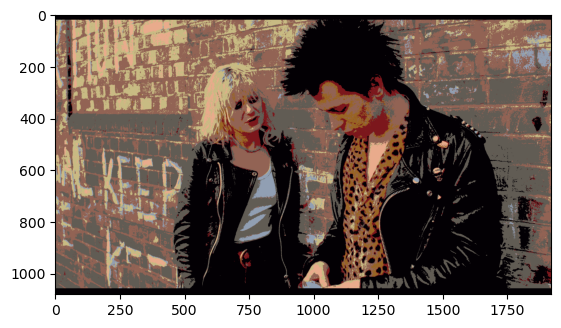

In [179]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

window_name = "color_mapper"

def v3_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

def map_colors(colors_to_map, img):
    img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i,j]
            lowest_distance = 999
            nearest_color = None
            for color in colors_to_map:
                distance = v3_distance(color, pixel)
                if distance < lowest_distance:
                    lowest_distance = distance
                    nearest_color = color
            img[i,j] = nearest_color
    return img
        


def get_color(event,x,y,flags,param):
    image = param[0]
    target_colors = param[1]

    if event == cv.EVENT_LBUTTONDOWN:
        color = image[y,x]
        # turn color into int rgb
        color = [int(color[2]), int(color[1]), int(color[0])]
        target_colors.append(color)

def get_points(image):
    color_list = []
    
    cv.namedWindow(window_name, cv.WINDOW_NORMAL)
    cv.imshow(window_name, image)
    cv.setMouseCallback(window_name, get_color,param=[image, color_list])

    while(1):
        cv.imshow(window_name, image)
        if cv.waitKey(20)==ord('r'):
            cv.destroyAllWindows()
            return color_list
        if cv.waitKey(20)==ord('q'):
            cv.destroyAllWindows()
            break

def separate_image_by_colors(img, colors):
    images = []
    for color in colors:
        img_c = np.zeros(img.shape, dtype=np.uint8)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                pixel = img[i,j]
                if np.all(pixel == color):
                    img_c[i,j] = 255
        images.append(img_c)
    return images

# return colors to image
def return_colors_to_image(images_color, target_colors):
    rebuilt_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(len(images_color)):
        for j in range(images_color[i].shape[0]-1):
            for k in range(images_color[i].shape[1]-1):
                if np.all(images_color[i][j,k] == 255):
                    # set color int
                    rebuilt_image[j,k] = [int(target_colors[i][0]), int(target_colors[i][1]), int(target_colors[i][2])]

    # fix black colors using most common color from neighboring pixels
    for i in range(rebuilt_image.shape[0]):
        for j in range(rebuilt_image.shape[1]):
            if np.all(rebuilt_image[i,j] == 0):
                # get neighboring pixels
                neighbors = []
                for k in range(-1,1):
                    for l in range(-1,1):
                        if i+k >= 0 and i+k < rebuilt_image.shape[0] and j+l >= 0 and j+l < rebuilt_image.shape[1] and rebuilt_image[i+k, j+l].any():
                            neighbors.append(tuple(rebuilt_image[i+k,j+l]))
                
                # get most common color
                most_common_color = max(set(neighbors), key=neighbors.count)
                rebuilt_image[i,j] = list(most_common_color)
    return rebuilt_image


image = cv.imread("sid-hd.png", cv.IMREAD_COLOR)
target_colors = get_points(image)

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
mapped_img = map_colors(target_colors, image_rgb)

# plot image and mapped
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
plt.imshow(mapped_img)
plt.show()

# get unique colors from image
image_colors = np.unique(mapped_img.reshape(-1, mapped_img.shape[2]), axis=0)
# plot colors
plt.imshow(image_colors.reshape(1,-1,3))
plt.show()

# split image by colors
images_color = separate_image_by_colors(mapped_img, target_colors)

# plot images
for i in range(len(images_color)):
    plt.subplot(1, len(images_color), i+1)
    plt.imshow(images_color[i]) 
plt.show()

# perform different morphological operations on images
kernel_size = 1
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))

# list of morphological operations
morph_operations = [cv.MORPH_OPEN, cv.MORPH_CLOSE, cv.MORPH_DILATE, cv.MORPH_ERODE]

for op in morph_operations:
    images_color_denoise = [cv.morphologyEx(img, op, kernel) for img in images_color]
    
    for i in range(len(images_color_denoise)):
        plt.subplot(1, len(images_color_denoise), i+1)
        plt.imshow(images_color_denoise[i])
    plt.show()

    rebuilt_image = return_colors_to_image(images_color_denoise, target_colors)
    
    plt.imshow(rebuilt_image)
    plt.show()

In [182]:
# save image using rgb colors
image_grb = cv.cvtColor(rebuilt_image, cv.COLOR_RGB2BGR)
cv.imwrite("sid-hd-rgb.png", image_grb)

True